In [298]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle
from Bio import Entrez
import requests
import json
from pandas.io.json import json_normalize
from bs4 import BeautifulSoup
from collections import defaultdict
from collections import Counter
import shutil
from urllib.parse import urlparse
from ast import literal_eval

import gensim
import nltk
from nltk.stem import WordNetLemmatizer
np.random.seed(2018)
from nltk.stem.porter import PorterStemmer
from string import punctuation
import pickle
from gensim.models.doc2vec import LabeledSentence
from sklearn.metrics.pairwise import cosine_similarity
import scipy

In [73]:
base_dir='/Volumes/Yuchen_Drive/Insight/OncoMatch'
onco_df=pickle.load(open(os.path.join(base_dir, "data/Oncologist_info_1470.pkl"),"rb"))

In [74]:
center_df=pd.read_csv(os.path.join(base_dir, 'data/nci_center.csv'))

In [102]:
onco_name = "Kenneth H. Yu"
onco_prefix = "+".join(onco_name.split())

In [81]:
base_api = 'https://ClinicalTrials.gov/api/query/full_studies?expr=heart+attack'

In [105]:
base_api = "https://clinicaltrials.gov/api/query/study_fields?expr=heart+attack&fields=NCTId,Condition,BriefTitle"

In [119]:
#base_api = "https://clinicaltrials.gov/api/query/study_fields?expr=heart+attack&fields=NCTId,Condition,BriefTitle"
base_api = "https://clinicaltrials.gov/api/query/study_fields?"
params = {
    'fmt':'JSON',
    'expr':'heart+attack',
    'fields':'NCTId,Condition,BriefTitle'
}
response = requests.get(base_api, params=params)
json.loads(response.text)

{'StudyFieldsResponse': {'APIVrs': '1.01.02',
  'DataVrs': '2020:01:22 22:39:59.462',
  'Expression': 'heart+attack',
  'NStudiesAvail': 327786,
  'NStudiesFound': 1508,
  'MinRank': 1,
  'MaxRank': 20,
  'NStudiesReturned': 20,
  'FieldList': ['NCTId', 'Condition', 'BriefTitle'],
  'StudyFields': [{'Rank': 1,
    'NCTId': ['NCT00929994'],
    'Condition': ['Transient Ischemic Attack'],
    'BriefTitle': ['Effects of Cardiac Rehabilitation for Individuals With Transient Ischemic Attack']},
   {'Rank': 2,
    'NCTId': ['NCT00536562'],
    'Condition': ['TIA (Transient Ischemic Attack)'],
    'BriefTitle': ['Cardiac Rehabilitation for TIA Patients']},
   {'Rank': 3,
    'NCTId': ['NCT00102128'],
    'Condition': ['Ischemic Heart Failure',
     'Ischemic Heart Disease',
     'Ischemic Cardiomyopathy'],
    'BriefTitle': ['Study to Examine the Safety and Effectiveness of Implanted Skeletal Muscle Cells (Cells Removed From the Thigh Muscle) Into Scarred Areas of Heart Muscle After Heart Att

In [137]:
base_api = "https://clinicaltrials.gov/api/query/study_fields?"
params = {
    'fmt':'JSON',
    'expr':onco_prefix+'+cancer',
    'fields':'NCTId,Condition,BriefTitle,Phase',
    'max_rnk':1000
}
response = requests.get(base_api, params=params)
response = json.loads(response.text)

In [141]:
num_studies = response['StudyFieldsResponse']['NStudiesFound']
print('num_studies: {}'.format(num_studies))

num_studies: 29


In [ ]:
num_clinical_trails=dict()
num_clinical_trails[onco_name]=num_studies

In [173]:
condition_dict=dict()
title_dict=dict()
phase_dict=dict()
for study in response['StudyFieldsResponse']['StudyFields']:
    condition_dict[study['NCTId'][0]] = study['Condition']        
    if len(study['BriefTitle']) > 0:
        title_dict[study['NCTId'][0]] = study['BriefTitle'][0]
    if len(study['Phase']) > 0:
        phase_dict[study['NCTId'][0]] = study['Phase'][0]

In [174]:
df1 = pd.DataFrame.from_dict(condition_dict, orient='index')
df2 = pd.DataFrame.from_dict(title_dict, orient='index', columns=['BriefTitle'])
df3 = pd.DataFrame.from_dict(phase_dict, orient='index', columns=['Phase'])

In [267]:
df1['Condition'] = df1.apply(lambda x:[i for i in x if i is not None],axis=1)

In [268]:
clinical_df=pd.concat([df2,df3],axis=1,sort=False)
clinical_df['Condition'] = df1.Condition
clinical_df.head()

,BriefTitle,Phase,Condition
NCT03213678,PI3K/mTOR Inhibitor LY3023414 in Treating Pati...,Phase 2,"[Advanced Malignant Solid Neoplasm, Ann Arbor ..."
NCT03233204,Olaparib in Treating Patients With Relapsed or...,Phase 2,"[Advanced Malignant Solid Neoplasm, Ann Arbor ..."
NCT03526250,Palbociclib in Treating Patients With Relapsed...,Phase 2,"[Advanced Malignant Solid Neoplasm, Recurrent ..."
NCT03155620,Targeted Therapy Directed by Genetic Testing i...,Phase 2,"[Advanced Malignant Solid Neoplasm, Ann Arbor ..."
NCT02750826,Breast Cancer WEight Loss Study (BWEL Study),Phase 3,"[Breast Carcinoma, [Breast Carcinoma, None, No..."


### Combined function

In [269]:
def get_clinicaltrial_info(onco_name):
    onco_prefix = "+".join(onco_name.split())
    base_api = "https://clinicaltrials.gov/api/query/study_fields?"
    params = {
        'fmt':'JSON',
        'expr':onco_prefix+'+cancer',
        'fields':'NCTId,Condition,BriefTitle,Phase',
        'max_rnk':1000
    }
    response = requests.get(base_api, params=params)
    response = json.loads(response.text)
    num_studies = response['StudyFieldsResponse']['NStudiesFound']
    print('{} has {} studies'.format(onco_name, num_studies))
    num_clinical_trails[onco_name]=num_studies
    
    if num_studies > 0:
        condition_dict=dict()
        title_dict=dict()
        phase_dict=dict()
        for study in response['StudyFieldsResponse']['StudyFields']:
            condition_dict[study['NCTId'][0]] = study['Condition']        
            if len(study['BriefTitle']) > 0:
                title_dict[study['NCTId'][0]] = study['BriefTitle'][0]
            if len(study['Phase']) > 0:
                phase_dict[study['NCTId'][0]] = study['Phase'][0]
    
        df1 = pd.DataFrame.from_dict(condition_dict, orient='index')
        df2 = pd.DataFrame.from_dict(title_dict, orient='index', columns=['BriefTitle'])
        df3 = pd.DataFrame.from_dict(phase_dict, orient='index', columns=['Phase'])
        df1['Condition'] = df1.apply(lambda x:[i for i in x if i is not None],axis=1)
        clinical_df=pd.concat([df2,df3],axis=1,sort=False)
        clinical_df['Condition'] = df1.Condition
        clinical_df.to_csv(os.path.join(base_dir, 'clinical_trial/{}_clinical_trial_info.csv'.format(onco_prefix)),index=True,index_label='NCTId')

In [270]:
num_clinical_trails=dict()

In [271]:
#onco_name = "Kenneth H. Yu"
for onco_name in onco_df.name:
    get_clinicaltrial_info(onco_name)

John A. Ridge has 716 studies
Howard West has 346 studies
Charles Roberts has 326 studies
Yuan Yuan has 202 studies
Steven Grant has 196 studies
Joseph Chao has 196 studies
James C. Moore has 195 studies
Peter Graham Rose has 182 studies
Robert D. Warren has 175 studies
John C. Barrett has 139 studies
Elizabeth A. Blair has 138 studies
Anne Moore has 129 studies
Michael E. Williams has 123 studies
George H. Perkins has 119 studies
Henry K. Lee has 114 studies
Y. Nancy You has 108 studies
Steven Martin has 107 studies
John D. Mitchell has 101 studies
Lewis R. Roberts has 97 studies
Michael S. Simon has 96 studies
Paul F. Mansfield has 95 studies
Sarah K. May has 94 studies
Steven K. Clinton has 91 studies
Paul D. Brown has 82 studies
Michael Roger Harrison has 81 studies
Joseph Anthony Arthur has 79 studies
Mark S. Collins has 72 studies
Randolph Marks has 71 studies
Edward B. Perkins has 68 studies
W. Michael Alberts has 65 studies
George R. Simon has 64 studies
Thomas J. Smith has 60 

Linda R. Duska has 7 studies
Ivan Borrello has 7 studies
Morie A. Gertz has 7 studies
Saranya Chumsri has 7 studies
Paula Silverman has 7 studies
Milind M. Javle has 7 studies
Kathleen M. Schmeler has 7 studies
Rogerio Lilenbaum has 7 studies
Craig C. Hofmeister has 7 studies
Rachel A. Freedman has 7 studies
William Thomas Stephenson has 7 studies
Mohammad Razaq has 7 studies
Steven J. Isakoff has 7 studies
Everett E. Vokes has 7 studies
Rita Nanda has 7 studies
Wen Wee Ma has 7 studies
John T. Sandlund has 7 studies
Martha Lacy has 7 studies
Anjali S. Advani has 7 studies
Jeremy S. Abramson has 7 studies
David Schiff has 7 studies
Richard J. Wong has 7 studies
Henry C. Pitot has 7 studies
Jeffrey Y.C. Wong has 7 studies
Zeina A. Nahleh has 7 studies
Harold J. Burstein has 7 studies
Suzanne George has 7 studies
Barbara Burtness has 7 studies
Elisabeth I. Heath has 7 studies
Miguel-Angel Perales has 7 studies
Tait D. Shanafelt has 7 studies
Keith Flaherty has 7 studies
Samuel Chung has 

Christos Fountzilas has 3 studies
Stephanie Gaillard has 3 studies
Scott Joseph Antonia has 3 studies
Rachid C. Baz has 3 studies
Martine Extermann has 3 studies
Jhanelle Elaine Gray has 3 studies
Kelly Hunt has 3 studies
Michael A. Curran has 3 studies
Jorg Dietrich has 3 studies
Samuel Singer has 3 studies
Randall F. Holcombe has 3 studies
Martin McCarter has 3 studies
Wilson I. Gonsalves has 3 studies
Sonali M. Smith has 3 studies
Stephen M. Hahn has 3 studies
Robert G. Maki has 3 studies
James C. Yao has 3 studies
Marilyn Huang has 3 studies
Zihai Li has 3 studies
David Raben has 3 studies
Mitesh J. Borad has 3 studies
Shirley S. Ong has 3 studies
Hyo S. Han has 3 studies
William R. Jarnagin has 3 studies
Jill N. Allen has 3 studies
Ryan D. Gentzler has 3 studies
Tracey L. O'Connor has 3 studies
Igor Puzanov has 3 studies
Jarushka Naidoo has 3 studies
Brian J. Czerniecki has 3 studies
Lisa Yee has 3 studies
Jamie E. Chaft has 3 studies
Olwen Mary Hahn has 3 studies
Anthony Frank Sh

Shreyaskumar Patel has 1 studies
Mitchell C. Posner has 1 studies
Eduardo Vilar Sanchez has 1 studies
W. K. Alfred Yung has 1 studies
Cullen M. Taniguchi has 1 studies
Patricia J. Eifel has 1 studies
Mariana Chavez-MacGregor has 1 studies
Larissa Meyer has 1 studies
Carmelita P. Escalante has 1 studies
Sarina Anne Piha-Paul has 1 studies
Tamila L. Kindwall-Keller has 1 studies
Pamela T. Soliman has 1 studies
Brian Andrew Jonas has 1 studies
Michael A. Warso has 1 studies
Robert J. Canter has 1 studies
Scott N. Gettinger has 1 studies
Ferdinandos Skoulidis has 1 studies
John Robert Hyngstrom has 1 studies
Thein H. O has 1 studies
Gabriel Lopez-Berestein has 1 studies
Amado J. Zurita has 1 studies
Dineo Khabele has 1 studies
Frank V. Fossella has 1 studies
David A. Liebner has 1 studies
Christiana Brenin has 1 studies
Kebede Begna has 1 studies
Julia A. Chapman has 1 studies
Michele Y. Halyard has 1 studies
Tanios S. Bekaii-Saab has 1 studies
Terri L. Parker has 1 studies
James E. Ruffer

Norma Azzam Grunspun has 0 studies
Sima Ehsani Chimeh has 0 studies
Paul Richard Kuefler has 0 studies
Arlyn J. Apollo has 0 studies
Carl Ola Landgren has 0 studies
Nima Sharifi has 0 studies
Bernard Chinnasami has 0 studies
Kenneth Wyman has 0 studies
Hari Anant Deshpande has 0 studies
Allen Ray Sing Chen has 0 studies
Tobias Neff has 0 studies
Richard J. James Battafarano has 0 studies
Drew M. Pardoll has 0 studies
John H. Fetting has 0 studies
Seth Corey has 0 studies
Douglas Wilmot Ball has 0 studies
Channing Judith Paller has 0 studies
Jaishri O'Neill Blakeley has 0 studies
Parkash S. Gill has 0 studies
Paul A. Masci has 0 studies
Melinda Lynne Yushak has 0 studies
Amanda R. Kirane has 0 studies
Susan Anitra Melin has 0 studies
Matteo Maria Trucco has 0 studies
Elaine Tat Lam has 0 studies
Omer Naci Koc has 0 studies
Ann L. Mellott has 0 studies
Brad L. Pohlman has 0 studies
Richard D. Schulick has 0 studies
Zaw Win Myint has 0 studies
Fadlo Raja Khuri has 0 studies
Susan B. LeGra

Swaminathan Padmanabhan Iyer has 0 studies
Beverly Ashleigh Guadagnolo has 0 studies
Celyne Bueno-Hume has 0 studies
John Frederick De Groot has 0 studies
Mediget Teshome has 0 studies
Roisin Eilish O'Cearbhaill has 0 studies
Stephen Yenzen Lai has 0 studies
Susan Lerner Cohn has 0 studies
Joaquina Celebre Baranda has 0 studies
Terry Tsue has 0 studies
Frederick G. Behm has 0 studies
Venkatadri Beeki has 0 studies
Don Lynn Gibbons has 0 studies
Janet Chen Tu has 0 studies
William Edgar Carson has 0 studies
Anthony Paul Conley has 0 studies
John Michael Skibber has 0 studies
Kenneth V. I. Rolston has 0 studies
David Ira Rosenthal has 0 studies
Michael Robert Migden has 0 studies
Ignacio Ivan Wistuba has 0 studies
Nita Karnik Lee has 0 studies
Russell Zelig Szmulewitz has 0 studies
Justin Paul Kline has 0 studies
Muaiad Kittaneh has 0 studies
Robert L. Grossman has 0 studies
John Patrick Galvin has 0 studies
Manana Elia has 0 studies
Jennifer Lynn McNeer has 0 studies
Selina Lai-ming Cho

In [274]:
num_clinical_trails_df = pd.DataFrame.from_dict(num_clinical_trails, orient='index', columns=['clinical_trial_num']).reset_index().rename(columns={'index':'name'})
num_clinical_trails_df.head()

,name,clinical_trial_num
0,John A. Ridge,716
1,Howard West,346
2,Charles Roberts,326
3,Yuan Yuan,202
4,Steven Grant,196


In [209]:
onco_df = pd.merge(onco_df, num_clinical_trails_df, left_on='name', right_on='name')
onco_df.head()

,name,degree,phone,center_name2,address,city_state,speciality,certificate,center_name,article_num,clinical_trial_num
0,John H. Glick,"MD, FASCO",(215) 662-6334,University of Pennsylvania-Abramson Cancer Center,"3400 Civic Center Blvd3rd Fl, Ste 3-300S","Philadelphia, PA 19104-5127, US","[Breast Cancer, Cancer Prevention]","[Internal Medicine, Medical Oncology]",Abramson Cancer Center,7,0
1,Arthur M. Feldman,MD,(215) 662-9801,University of Pennsylvania-Abramson Cancer Center,Penn Presbyterian Medcl Ctr51 N 39th St MAB St...,"Philadelphia, PA 19104, US","[Breast Cancer, Geriatrics Oncology]","[Internal Medicine, Medical Oncology]",Abramson Cancer Center,0,1
2,David M. Mintzer,MD,Search for Phone Number,Abramson Cancer Center at Pennsylvania Hospital,230 W Washington Sq Fl 2,"Philadelphia, PA 19106-3500, US","[Breast Cancer, Lung Cancer, Palliative Care/E...","[Hematology, Hospice and Palliative Medicine, ...",Abramson Cancer Center,13,0
3,David J. Vaughn,MD,(215) 349-8140,University of Pennsylvania-Abramson Cancer Center,PCAM South 10-1143400 Civic Center Blvd,"Philadelphia, PA 19104, US","[Bladder Cancer, Prostate Cancer, Testicular C...",[Medical Oncology],Abramson Cancer Center,86,1
4,Charles John Schneider,"MD, FACP",Search for Phone Number,"Hospital of the University of Pennsylvania, Ab...",Pereleman Center for Advanced Medicine3400 Civ...,"Philadelphia, PA 19104, US","[Clinical Research, Developmental Therapeutics...",[Medical Oncology],Abramson Cancer Center,0,5


In [219]:
onco_df.shape

(1470, 11)

In [212]:
onco_df.to_csv(os.path.join(base_dir, "data/Oncologist_info_clinicaltrial_1470.csv"),index=False)

In [214]:
pickle.dump(onco_df, open(os.path.join(base_dir, "data/Oncologist_info_clinicaltrial_1470.pkl"), "wb"))

In [215]:
onco_df=pickle.load(open(os.path.join(base_dir, "data/Oncologist_info_clinicaltrial_1470.pkl"),"rb"))

In [221]:
onco_df=pd.read_csv(os.path.join(base_dir, "data/Oncologist_info_clinicaltrial_1470.csv"))
onco_df.head()

,name,degree,phone,center_name2,address,city_state,speciality,certificate,center_name,article_num,clinical_trial_num
0,John H. Glick,"MD, FASCO",(215) 662-6334,University of Pennsylvania-Abramson Cancer Center,"3400 Civic Center Blvd3rd Fl, Ste 3-300S","Philadelphia, PA 19104-5127, US","['Breast Cancer', 'Cancer Prevention']","['Internal Medicine', 'Medical Oncology']",Abramson Cancer Center,7,0
1,Arthur M. Feldman,MD,(215) 662-9801,University of Pennsylvania-Abramson Cancer Center,Penn Presbyterian Medcl Ctr51 N 39th St MAB St...,"Philadelphia, PA 19104, US","['Breast Cancer', 'Geriatrics Oncology']","['Internal Medicine', 'Medical Oncology']",Abramson Cancer Center,0,1
2,David M. Mintzer,MD,Search for Phone Number,Abramson Cancer Center at Pennsylvania Hospital,230 W Washington Sq Fl 2,"Philadelphia, PA 19106-3500, US","['Breast Cancer', 'Lung Cancer', 'Palliative C...","['Hematology', 'Hospice and Palliative Medicin...",Abramson Cancer Center,13,0
3,David J. Vaughn,MD,(215) 349-8140,University of Pennsylvania-Abramson Cancer Center,PCAM South 10-1143400 Civic Center Blvd,"Philadelphia, PA 19104, US","['Bladder Cancer', 'Prostate Cancer', 'Testicu...",['Medical Oncology'],Abramson Cancer Center,86,1
4,Charles John Schneider,"MD, FACP",Search for Phone Number,"Hospital of the University of Pennsylvania, Ab...",Pereleman Center for Advanced Medicine3400 Civ...,"Philadelphia, PA 19104, US","['Clinical Research', 'Developmental Therapeut...",['Medical Oncology'],Abramson Cancer Center,0,5


### Number of clinical trials for each oncologist

In [265]:
clinical_trial_counts = onco_df.clinical_trial_num.value_counts().to_frame().reset_index().rename(columns={'clinical_trial_num':'counts','index':'clinical_trial_num'}).sort_values(by=['clinical_trial_num'])
clinical_trial_counts.head(20)

,clinical_trial_num,counts
0,0,485
1,1,211
2,2,151
3,3,105
4,4,81
5,5,66
7,6,54
6,7,56
11,8,18
8,9,22


In [231]:
print('Maximum number of clinical trials: {}'.format(onco_df.clinical_trial_num.max()))

Maximum number of clinical trials: 716


In [261]:
onco_df = onco_df.sort_values(by=['clinical_trial_num'],ascending=False)
i=1
while i<= 20:
    for index, row in onco_df.head(20).iterrows():
        print('Rank {}: {} has {} clinical trials'.format(i, row['name'], row['clinical_trial_num']))
        i+=1

Rank 1: John A. Ridge has 716 clinical trials
Rank 2: Howard West has 345 clinical trials
Rank 3: Charles Roberts has 325 clinical trials
Rank 4: Yuan Yuan has 202 clinical trials
Rank 5: Steven Grant has 196 clinical trials
Rank 6: Joseph Chao has 195 clinical trials
Rank 7: James C. Moore has 194 clinical trials
Rank 8: Peter Graham Rose has 181 clinical trials
Rank 9: Robert D. Warren has 175 clinical trials
Rank 10: John C. Barrett has 139 clinical trials
Rank 11: Elizabeth A. Blair has 138 clinical trials
Rank 12: Anne Moore has 129 clinical trials
Rank 13: Michael E. Williams has 122 clinical trials
Rank 14: George H. Perkins has 119 clinical trials
Rank 15: Henry K. Lee has 114 clinical trials
Rank 16: Y. Nancy You has 108 clinical trials
Rank 17: Steven Martin has 107 clinical trials
Rank 18: John D. Mitchell has 101 clinical trials
Rank 19: Lewis R. Roberts has 97 clinical trials
Rank 20: Michael S. Simon has 96 clinical trials


Text(0.5, 0, 'Number of clinical trials')

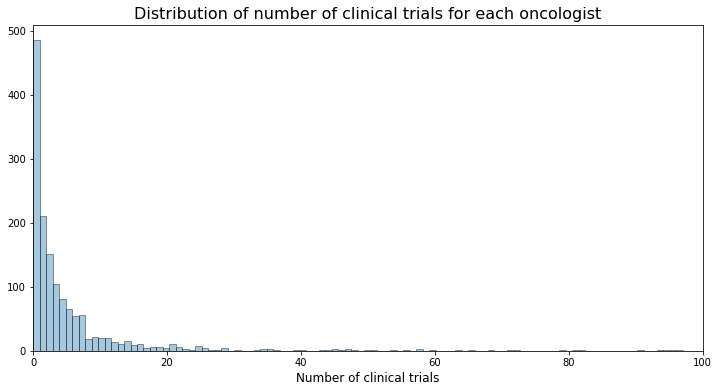

In [241]:
fig,ax=plt.subplots(1,1,figsize=(12,6))
sns.distplot(onco_df.clinical_trial_num.sort_values(ascending=False).iloc[18:].values,hist=True,kde=False,bins=100,ax=ax,hist_kws={'edgecolor':'black'})
ax.set_xlim(0,100)
ax.set_title('Distribution of number of clinical trials for each oncologist',fontsize=16)
ax.set_xlabel('Number of clinical trials',fontsize=12)

In [262]:
onco_df.head()

,name,degree,phone,center_name2,address,city_state,speciality,certificate,center_name,article_num,clinical_trial_num
311,John A. Ridge,"MD, PhD",Search for Phone Number,Fox Chase Cancer Center,333 Cottman Ave,"Philadelphia, PA 19111-2412, US","['Head and Neck Cancer', 'Melanoma', 'Endocrin...",['Surgical Oncology'],Fox Chase Cancer Center,103,716
127,Howard West,MD,(626) 775-3372,City of Hope Comprehensive Cancer Center,1500 E. Duarte Road,"Duarte, CA 91010-3000, US","['Lung Cancer', 'Pain & Symptom Management']","['Internal Medicine', 'Medical Oncology']",City of Hope Comprehensive Cancer Center,65,345
757,Charles Roberts,"MD, PhD",Search for Phone Number,St. Jude Children's Research Hospital,262 Danny Thomas Pl,"Memphis, TN 38105-3678, US",[],[],St. Jude Children's Research Hospital,68,325
121,Yuan Yuan,"MD, PhD",(626) 256-4673,City of Hope Medical Center,1500 Duarte Rd,"Duarte, CA 91010-3012, US",['Developmental Therapeutics'],['Internal Medicine'],City of Hope Comprehensive Cancer Center,303,202
1216,Steven Grant,MD,(877) 462-7739,Virginia Commonwealth University Health Sciences,Dalton Oncology Clinic1300 E Marshall St,"Richmond, VA 23298, US",['Developmental Therapeutics'],"['Hematology', 'Internal Medicine', 'Medical O...",University of Virginia Cancer Center,250,196


(0, 100)

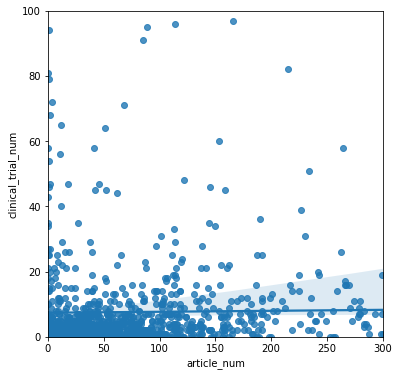

In [264]:
fig, ax = plt.subplots(1,1,figsize = (6,6))
sns.regplot(x='article_num',y='clinical_trial_num',data=onco_df,ax=ax)
ax.set_xlim(0,300)
ax.set_ylim(0,100)

### Cancer types for clinical trials run by each oncologist

In [292]:
conditions_set = set()
for onco_name in onco_df.name:
    onco_prefix = "+".join(onco_name.split())
    if num_clinical_trails[onco_name] > 0:
        subset_df=pd.read_csv(os.path.join(base_dir, 'clinical_trial/{}_clinical_trial_info.csv'.format(onco_prefix)),converters={"Condition":literal_eval})
        for conditions in subset_df.Condition:
            for i in conditions:
                conditions_set.add(i)

In [293]:
len(conditions_set)

4833

In [294]:
conditions_set

{'Stage IIIb Lung Cancer',
 'Recurrent Pancreatic Adenocarcinoma',
 'Acute Myeloid Leukemia With Gene Mutations',
 'ER',
 'Previously Untreated Acute Myeloid Leukemia',
 'Stage IIA Lung Non-Small Cell Carcinoma AJCC v7',
 'Metastatic Ewing Sarcoma',
 'Lymphoplasmacytic Lymphoma',
 'Lung Carcinoma',
 'Malignant Mesothelioma',
 'Paget Disease of the Breast With Intraductal Carcinoma',
 'Refractory T-Cell Lymphoma',
 'Recurrent Grade 3 Follicular Lymphoma',
 'Pancreatic Vipoma',
 'Human Papillomavirus (HPV) 16+ Relapsed/Refractory Cancer',
 'Patients With Leptomeningeal Disease',
 'Ovarian Mixed Germ Cell Tumor',
 'Vulvar Carcinoma',
 'Refractory Anaplastic Large Cell Lymphoma',
 'Wilms Tumor',
 'Stage IVA Bladder Cancer',
 'Deleterious BRCA1 Gene Mutation',
 'Ann Arbor Stage IV Marginal Zone Lymphoma',
 'Adult B Lymphoblastic Lymphoma',
 'FLT3 Tyrosine Kinase Domain Point Mutation',
 'Ovarian Gynandroblastoma',
 'Hodgkin Lymphoma in Remission',
 'RAS Mutation',
 't(9;22)',
 'Advanced or 

In [319]:
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        temp=WordNetLemmatizer().lemmatize(token).lower()
        if len(temp)>1 and temp not in stop_words:
            result.append(temp)
    return list(set(result))

In [320]:
stop_word1 = gensim.parsing.preprocessing.STOPWORDS   ## 337
stop_word2 = nltk.corpus.stopwords.words('english')   ## 179
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
custom_words = ["fig", "figure", "et", "al", "al.", "also",
                "data", "analyze", "study", "table", "using",
                "method", "result", "conclusion", "author", 
                "find", "found", "show", '"', "’", "“", "”", 'analysis','analyses','analyzed','results','figures'
                "assayed", "assay", "assays","figures", "figure","data", "sample","samples","table","tables",
                'proteins','protein','cells','cell','genes','gene',
                'mutated','mutation','mutational','mutations','mutate','mutant','mutants',
                'cancer','cancers','tumor','tumors','variant','variants','biology','biological']
stop_words = set(list(stop_word1)+stop_word2+list(punct)+custom_words)   ## 493

In [315]:
def annotate_abstract(text):
    cancer_type=[]
    cancer_list1=['adrenocortical', 'anal', 'appendix', 'bladder', 'bone', 'breast', 'cervical', 'gallbladder', 'ovarian', 'penile', 'prostate', 'rectal', 'skin', 'thyroid', 'vaginal', 'vulvar', 'urethral', 'parathyroid',]
    cancer_list2=['carcinoid', 'pituitary', 'wilms', 'rhabdoid', 'brain']
    cancer_list3=['melanoma', 'mesothelioma', 'neuroblastoma', 'osteosarcoma', 'pheochromocytoma', 'retinoblastoma', 'rhabdomyosarcoma', 'sarcoma']
    for token in text:
        if token in cancer_list1:
            cancer_type.append(token.capitalize()+ ' Cancer')
        if token in cancer_list2:
            cancer_type.append(token.capitalize()+ ' Tumor')
        if token in cancer_list3:
            cancer_type.append(token.capitalize())
    if len(set(text).intersection(set(['bile','duct'])))==2:
        cancer_type.append('Bile Duct Cancer')
    if len(set(text).intersection(set(['colorectal', 'colon'])))>0:
        cancer_type.append('Colorectal Cancer')
    if len(set(text).intersection(set(['cardiac', 'heart'])))>0:
        cancer_type.append('Cardiac Tumors')
    if len(set(text).intersection(set(['endometrial', 'uterine', 'endometrium', 'uterus'])))>0:
        cancer_type.append('Endometrial Cancer')
    if len(set(text).intersection(set(['esophageal', 'esophagus'])))>0:
        cancer_type.append('Esophageal Cancer')
    if len(set(text).intersection(set(['ewing', 'sarcoma'])))==2:
        cancer_type.append('Ewing Sarcoma')
    if len(set(text).intersection(set(['fallopian', 'tube'])))==2:
        cancer_type.append('Fallopian Tube Cancer')
    if len(set(text).intersection(set(['gastric', 'stomach'])))>0:
        cancer_type.append('Gastric Cancer')
    if len(set(text).intersection(set(['gastrointestinal', 'stromal'])))>0:
        if len(set(text).intersection(set(['gastrointestinal', 'stromal'])))==2:
            cancer_type.append('Gastrointestinal Stromal Tumor (GIST)')
        else:
            cancer_type.append('Gastrointestinal Tumor')
    if len(set(text).intersection(set(['esthesioneuroblastoma', 'hypopharyngeal', 'laryngeal', 'nasopharyngeal', 'pharyngeal', 'salivary', 'oropharyngeal', 'neck'])))>0:
        cancer_type.append('Head and Neck Cancer')
    if len(set(text).intersection(set(['kidney', 'renal'])))>0:
        cancer_type.append('Kidney Cancer')
    if 'leukemia' in text:
        cancer_type.append('Leukemia')
        if 'acute' in text:
            if 'lymphoblastic' in text:
                cancer_type.append('Acute Lymphoblastic Leukemia (ALL)')
            if 'myeloid' in text:
                cancer_type.append('Acute Myeloid Leukemia (AML)')
        if 'chronic' in text:
            if 'lymphocytic' in text:
                cancer_type.append('Chronic Lymphocytic Leukemia (CLL)')
            if 'myelogenous' in text:
                cancer_type.append('Chronic Myelogenous Leukemia (CML)')
        if 'hairy' in text:
            cancer_type.append('Hairy Cell Leukemia')
    if len(set(text).intersection(set(['liver', 'hepatocellular', 'hepatocyte', 'hepatoblastoma'])))>0:
        cancer_type.append('Liver Cancer')
    if len(set(text).intersection(set(['lung', 'bronchial', 'pleuropulmonar', 'tracheobronchial'])))>0:
        cancer_type.append('Lung Cancer')
    if 'lymphoma' in text:
        cancer_type.append('Lymphoma')
        if 'burkitt' in text:
            cancer_type.append('Burkitt Lymphoma')
        if len(set(text).intersection(set(['mycosis', 'fungoides'])))==2:
            cancer_type.append('Mycosis Fungoides')
    if len(set(text).intersection(set(['multiple', 'myeloma'])))==2:
        cancer_type.append('Multiple Myeloma')
    if len(set(text).intersection(set(['myeloproliferative', 'myelodysplastic'])))>0:
        cancer_type.append('Myeloproliferative Neoplasms')
    if len(set(text).intersection(set(['pancreatic', 'pancreas'])))>0:
        cancer_type.append('Pancreatic Cancer')
    if len(set(text).intersection(set(['testicular', 'testicle', 'testicles', 'testis'])))>0:
        cancer_type.append('Testicular Cancer')
    return cancer_type

In [344]:
doctor2clinical_dict={}

In [345]:
for onco_name in onco_df.name:
    onco_prefix = "+".join(onco_name.split())
    if num_clinical_trails[onco_name] > 0:
        subset_df=pd.read_csv(os.path.join(base_dir, 'clinical_trial/{}_clinical_trial_info.csv'.format(onco_prefix)),converters={"Condition":literal_eval})
        subset_df['condition_processed']=subset_df.Condition.apply(lambda x:preprocess(" ".join(x)))
        subset_df['cancer_type2']=subset_df.condition_processed.apply(lambda x:annotate_abstract(x))
        doctor2clinical_dict[onco_name] = list(set(subset_df.cancer_type2.values.sum()))
        #subset_df.to_csv(os.path.join(base_dir, 'clinical_trial/{}_clinical_trial_info_annot.csv'.format(onco_prefix)),index=False)

In [346]:
len(doctor2clinical_dict)

985

In [347]:
pickle.dump(doctor2clinical_dict, open(os.path.join(base_dir, "data/doctor2clinical_dict.pkl"), "wb"))

In [348]:
doctor2clinical_dict=pickle.load(open(os.path.join(base_dir, "data/doctor2clinical_dict.pkl"),"rb"))

In [355]:
doctor2clinical_dict_df = pd.DataFrame.from_dict(doctor2clinical_dict,orient='index')
doctor2clinical_dict_df['cancer_types2'] = doctor2clinical_dict_df.apply(lambda x:[i for i in x if i is not None],axis=1)
doctor2clinical_dict_df = doctor2clinical_dict_df.loc[:,'cancer_types2'].to_frame()
doctor2clinical_dict_df.head()

,cancer_types2
John A. Ridge,"[Chronic Myelogenous Leukemia (CML), Rectal Ca..."
Howard West,"[Rectal Cancer, Thyroid Cancer, Bile Duct Canc..."
Charles Roberts,"[Rectal Cancer, Thyroid Cancer, Bile Duct Canc..."
Yuan Yuan,"[Rectal Cancer, Thyroid Cancer, Colorectal Can..."
Steven Grant,"[Chronic Myelogenous Leukemia (CML), Rectal Ca..."


In [356]:
doctor2clinical_dict_df.to_csv(os.path.join(base_dir, 'data/doctor2clinical_dict_df.csv'),index=True,index_label='name')

In [350]:
print('Number of oncologists have clinical trials: {}'.format(len(doctor2clinical_dict)))

Number of oncologists have clinical trials: 985


#### Get the numebr of clinical trials for each cancer type for each doctor

In [413]:
doctor2clinical_dict2={}

In [414]:
for onco_name in onco_df.name:
    onco_prefix = "+".join(onco_name.split())
    if num_clinical_trails[onco_name] > 0:
        subset_df=pd.read_csv(os.path.join(base_dir, 'clinical_trial/{}_clinical_trial_info.csv'.format(onco_prefix)),converters={"Condition":literal_eval})
        subset_df['condition_processed']=subset_df.Condition.apply(lambda x:preprocess(" ".join(x)))
        subset_df['cancer_type2']=subset_df.condition_processed.apply(lambda x:annotate_abstract(x))
        doctor2clinical_dict2[onco_name] = Counter(subset_df.cancer_type2.values.sum())

In [506]:
#doctor2clinical_dict2

In [416]:
pickle.dump(doctor2clinical_dict2, open(os.path.join(base_dir, "data/doctor2clinical_dict2.pkl"), "wb"))

In [417]:
doctor2clinical_dict2=pickle.load(open(os.path.join(base_dir, "data/doctor2clinical_dict2.pkl"),"rb"))

In [418]:
doctor2clinical_dict2_df=pd.DataFrame.from_dict(doctor2clinical_dict2,orient='index')

In [419]:
doctor2clinical_dict2_df.head()

,Brain Tumor,Breast Cancer,Head and Neck Cancer,Ovarian Cancer,Fallopian Tube Cancer,Leukemia,Lymphoma,Myeloproliferative Neoplasms,Colorectal Cancer,Prostate Cancer,...,Osteosarcoma,Multiple Myeloma,Chronic Myelogenous Leukemia (CML),Hairy Cell Leukemia,Cardiac Tumors,Penile Cancer,Retinoblastoma,Burkitt Lymphoma,Mycosis Fungoides,Adrenocortical Cancer
Aaron Rapoport,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,...,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Aarti K. Bhatia,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Abdulraheem Yacoub,NaN,NaN,NaN,NaN,NaN,1.0,NaN,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Abenaa M. Brewster,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Abhimanyu Ghose,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [422]:
doctor2clinical_dict2_df.to_csv(os.path.join(base_dir, 'data/doctor2clinical_dict2_df.csv'),index=True,index_label='name')

In [424]:
doctor2clinical_dict2_df=pd.read_csv(os.path.join(base_dir, 'data/doctor2clinical_dict2_df.csv'),index_col='name')

In [426]:
doctor2clinical_dict2_df.loc['John A. Ridge','Breast Cancer']

122.0

#### Get clinical trials for each cancer type for each doctor -- Cancer - Doctor - Clinical trial

In [529]:
for cancer_type in cancer_types:
    cancer_prefix="_".join(i.lower() for i in cancer_type.split())
    temp_dict1=defaultdict(list)
    temp_dict2=defaultdict(list)
    temp_dict3=defaultdict(list)
    temp_dict4=defaultdict(list)
    temp_dict5=defaultdict(list)
    index=0
    for onco_name in onco_df.name:
        onco_prefix = "+".join(onco_name.split())
        if num_clinical_trails[onco_name] > 0:
            subset_df=pd.read_csv(os.path.join(base_dir, 'clinical_trial/{}_clinical_trial_info_annot.csv'.format(onco_prefix)),converters={"Condition":literal_eval, "cancer_type2":literal_eval})
            for i,row in subset_df.iterrows():
                for j in row.cancer_type2:
                    if j==cancer_type:
                        index+=1
                        temp_dict1[index] = row.NCTId
                        temp_dict2[index] = onco_name
                        temp_dict3[index] = row.BriefTitle
                        temp_dict4[index] = row.Phase if type(row.Phase)==str and 'Phase' in row.Phase else 'NA'
                        temp_dict5[index] = row.Condition
    df1 = pd.DataFrame.from_dict(temp_dict1, orient='index', columns=['NCTId'])
    df2 = pd.DataFrame.from_dict(temp_dict2, orient='index', columns=['name'])
    df3 = pd.DataFrame.from_dict(temp_dict3, orient='index', columns=['BriefTitle'])
    df4 = pd.DataFrame.from_dict(temp_dict4, orient='index', columns=['Phase'])
    df5 = pd.DataFrame.from_dict(temp_dict5,orient='index')
    df5['Condition'] = df5.apply(lambda x:", ".join([i for i in x if i is not None]),axis=1)
    df5 = df5.loc[:,'Condition'].to_frame()
    
    temp_df=pd.concat([df1,df2,df3,df4,df5],axis=1,sort=False)
    temp_df['cancer_type'] = cancer_type
    temp_df.to_csv(os.path.join(base_dir, 'clinical_trial/{}_clinical_trial_info.csv'.format(cancer_prefix)),index=False)

In [527]:
type(np.nan)==float

True

In [519]:
np.isnan(np.nan)

True

In [514]:
temp_df.shape

(2333, 6)

In [509]:
subset_df.head()

,NCTId,BriefTitle,Phase,Condition,condition_processed,cancer_type2
0,NCT01142401,Fulvestrant With or Without Bortezomib in Pati...,Phase 2,"[Estrogen Receptor Positive, Stage IIIB Breast...","['receptor', 'breast', 'iiic', 'stage', 'posit...",['Breast Cancer']


In [498]:
temp_df.Condition[4]

'Stage II Breast Cancer Stage IIIA Breast Cancer'

In [477]:
onco_name = "John A. Ridge"
onco_prefix = "+".join(onco_name.split())
subset_df=pd.read_csv(os.path.join(base_dir, 'clinical_trial/{}_clinical_trial_info_annot.csv'.format(onco_prefix)),converters={"Condition":literal_eval, "cancer_type2":literal_eval, "condition_processed":literal_eval})

In [478]:
subset_df.head()

,NCTId,BriefTitle,Phase,Condition,condition_processed,cancer_type2
0,NCT00671710,Study of Aminolevulinic Acid to Enhance Visual...,Phase 1,[Brain Tumors],[brain],[Brain Tumor]
1,NCT00003854,Prognostic Study of Sentinel Lymph Node and Bo...,Phase 3,[Breast Cancer],[breast],[Breast Cancer]
2,NCT00720083,Chemotherapy and Radiation Therapy (RT) With o...,Phase 2,[Head and Neck Cancer],"[head, neck]",[Head and Neck Cancer]
3,NCT01124695,Tamoxifen Citrate in Treating Patients With Me...,Phase 2,[Breast Cancer],[breast],[Breast Cancer]
4,NCT01167712,Paclitaxel and Carboplatin With or Without Bev...,Phase 3,"[Fallopian Tube Endometrioid Adenocarcinoma, F...","[ovarian, seromucinous, carcinoma, iia, adenoc...","[Ovarian Cancer, Fallopian Tube Cancer]"


In [479]:
cancer_type

'Breast Cancer'

In [480]:
test_dict={}
index=0
for i,row in subset_df.iterrows():
    for j in row.cancer_type2:
        if j==cancer_type:
            index+=1
            test_dict[index] = row.Condition

In [482]:
len(test_dict)

122

In [486]:
df5 = pd.DataFrame.from_dict(test_dict,orient='index')
df5['Condition'] = df5.apply(lambda x:[i for i in x if i is not None],axis=1)
df5 = df5.loc[:,'Condition'].to_frame()
df5.head()

,Condition
1,[Breast Cancer]
2,[Breast Cancer]
3,[Breast Carcinoma]
4,"[Stage II Breast Cancer, Stage IIIA Breast Can..."
5,[Node Positive HER2 Negative Breast Cancer]


In [456]:
temp_df.head()

,NCTId,name,BriefTitle,Phase,Condition,cancer_type
1,NCT00003854,John A. Ridge,Prognostic Study of Sentinel Lymph Node and Bo...,Phase 3,[Breast Cancer],Breast Cancer
2,NCT01124695,John A. Ridge,Tamoxifen Citrate in Treating Patients With Me...,Phase 2,[Breast Cancer],Breast Cancer
3,NCT00087178,John A. Ridge,Comparison of Two Combination Chemotherapy Reg...,Phase 3,[Breast Cancer],Breast Cancer
4,NCT01242800,John A. Ridge,Early Surgery or Standard Palliative Therapy i...,Phase 3,[Breast Cancer],Breast Cancer
5,NCT00075764,John A. Ridge,S0226 Anastrozole With or Without Fulvestrant ...,Phase 3,[Breast Cancer],Breast Cancer


In [458]:
subset_df.shape

(1, 4)

In [454]:
subset_df.Condition.values

array([list(['Estrogen Receptor Positive', 'Stage IIIB Breast Cancer', 'Stage IIIC Breast Cancer', 'Stage IV Breast Cancer'])],
      dtype=object)

### Check oncologists with both publications and clincal -- doctor2cancerclinical_dict

In [352]:
doctor2pmid_1153_dict_df=pd.read_csv(os.path.join(base_dir, 'data/doctor2pmid_1153_dict_df.csv'),converters={"pmid":literal_eval})

In [353]:
doctor2pmid_1153_dict_df.head()

,name,pmid
0,John H. Glick,"[19863338, 18621616, 18591552, 15210738, 12712..."
1,David M. Mintzer,"[23233720, 22154117, 20053760, 18758307, 17573..."
2,David J. Vaughn,"[29848605, 29617189, 29590008, 29534941, 29523..."
3,Marcia S. Brose,"[30832606, 29704768, 29657135, 29656442, 29466..."
4,Robert G. Maki,"[31208434, 31142482, 30664786, 30575484, 30383..."


In [357]:
doctor2clinical_dict_df=pd.read_csv(os.path.join(base_dir, 'data/doctor2clinical_dict_df.csv'),converters={"cancer_types2":literal_eval})

In [358]:
doctor2clinical_dict_df.head()

,name,cancer_types2
0,John A. Ridge,"[Chronic Myelogenous Leukemia (CML), Rectal Ca..."
1,Howard West,"[Rectal Cancer, Thyroid Cancer, Bile Duct Canc..."
2,Charles Roberts,"[Rectal Cancer, Thyroid Cancer, Bile Duct Canc..."
3,Yuan Yuan,"[Rectal Cancer, Thyroid Cancer, Colorectal Can..."
4,Steven Grant,"[Chronic Myelogenous Leukemia (CML), Rectal Ca..."


In [359]:
doctor2cancer_dict_df=pd.read_csv(os.path.join(base_dir, 'data/doctor2cancer_dict_df.csv'),converters={"cancer_type":literal_eval})
doctor2cancer_dict_df.head()

,name,cancer_type
0,Andrea Silber,"[Breast Cancer, Cardiac Tumors, Vaginal Cancer]"
1,Celyne Bueno-Hume,[Breast Cancer]
2,Kathleen N. Moore,"[Breast Cancer, Lung Cancer, Leukemia, Colorec..."
3,Hossein Borghaei,"[Breast Cancer, Lung Cancer, Leukemia, Colorec..."
4,Eddy J. Chen,"[Breast Cancer, Prostate Cancer]"


In [360]:
doctor2cancer_dict_df.shape

(1129, 2)

In [366]:
doctor_cancertpyes_both = np.intersect1d(doctor2cancer_dict_df.name, doctor2clinical_dict_df.name)

In [367]:
print('Number of oncologists have both publications and clinical trials with specific cancer types: {}'.format(len(doctor_cancertpyes_both)))

Number of oncologists have both publications and clinical trials with specific cancer types: 880


In [368]:
doctor2cancer_dict=pickle.load(open(os.path.join(base_dir, "data/doctor2cancer_dict.pkl"),"rb"))
doctor2clinical_dict=pickle.load(open(os.path.join(base_dir, "data/doctor2clinical_dict.pkl"),"rb"))

In [369]:
doctor_cancertpyes_both_dict={}
for doctor in doctor_cancertpyes_both:
    doctor_cancertpyes_both_dict[doctor] = list(set(doctor2cancer_dict[doctor]) & set(doctor2clinical_dict[doctor]))

In [371]:
doctor_cancertpyes_both_dict

{'Aaron Rapoport': ['Leukemia', 'Lymphoma', 'Multiple Myeloma'],
 'Aarti K. Bhatia': ['Head and Neck Cancer'],
 'Abdulraheem Yacoub': ['Leukemia'],
 'Abenaa M. Brewster': ['Breast Cancer'],
 'Abhimanyu Ghose': ['Lung Cancer'],
 'Abhinav Deol': ['Multiple Myeloma', 'Lymphoma', 'Leukemia'],
 'Abhishek A Solanki': ['Prostate Cancer'],
 'Adam Brufsky': ['Prostate Cancer',
  'Breast Cancer',
  'Rectal Cancer',
  'Liver Cancer',
  'Colorectal Cancer',
  'Skin Cancer',
  'Melanoma',
  'Lung Cancer',
  'Ovarian Cancer',
  'Bladder Cancer',
  'Kidney Cancer',
  'Brain Tumor'],
 'Adi Diab': ['Melanoma'],
 'Aditi Shastri': ['Myeloproliferative Neoplasms'],
 'Aditya Bardia': ['Prostate Cancer',
  'Breast Cancer',
  'Cervical Cancer',
  'Ovarian Cancer',
  'Pancreatic Cancer',
  'Bladder Cancer',
  'Lung Cancer'],
 'Afshin Dowlati': ['Gallbladder Cancer',
  'Bile Duct Cancer',
  'Esophageal Cancer',
  'Lung Cancer',
  'Liver Cancer'],
 'Ahmad A. Tarhini': ['Melanoma', 'Skin Cancer', 'Lung Cancer'],

In [386]:
pickle.dump(doctor_cancertpyes_both_dict, open(os.path.join(base_dir, "data/doctor2cancerclinical_dict.pkl"), "wb"))

In [387]:
doctor2cancerclinical_dict=pickle.load(open(os.path.join(base_dir, "data/doctor2cancerclinical_dict.pkl"),"rb"))

In [393]:
doctor2cancerclinical_dict_df = pd.DataFrame.from_dict(doctor2cancerclinical_dict,orient='index')
doctor2cancerclinical_dict_df['cancer_type'] = doctor2cancerclinical_dict_df.apply(lambda x:[i for i in x if i is not None],axis=1)
doctor2cancerclinical_dict_df = doctor2cancerclinical_dict_df.loc[:,'cancer_type'].to_frame()
doctor2cancerclinical_dict_df['cancer_type_num'] = doctor2cancerclinical_dict_df.cancer_type.apply(lambda x:len(x))
doctor2cancerclinical_dict_df.head()

,cancer_type,cancer_type_num
Aaron Rapoport,"[Leukemia, Lymphoma, Multiple Myeloma]",3
Aarti K. Bhatia,[Head and Neck Cancer],1
Abdulraheem Yacoub,[Leukemia],1
Abenaa M. Brewster,[Breast Cancer],1
Abhimanyu Ghose,[Lung Cancer],1


In [394]:
doctor2cancerclinical_dict_df.cancer_type_num.value_counts().to_frame().reset_index().rename(columns={'cancer_type_num':'counts','index':'cancer_type_num'})

,cancer_type_num,counts
0,1,307
1,2,169
2,3,105
3,0,84
4,4,65
5,5,26
6,7,23
7,6,21
8,8,16
9,9,11


#### 880-84=796 oncologists have at least one cancer type showing up in both publications and clinical trials

In [395]:
doctor2cancerclinical_dict_df.to_csv(os.path.join(base_dir, 'data/doctor2cancerclinical_dict_df.csv'),index=True,index_label='name')

In [396]:
doctor2cancerclinical_dict_df=pd.read_csv(os.path.join(base_dir, 'data/doctor2cancerclinical_dict_df.csv'),converters={"cancer_type":literal_eval})

In [397]:
doctor2cancerclinical_dict_df.head()

,name,cancer_type,cancer_type_num
0,Aaron Rapoport,"[Leukemia, Lymphoma, Multiple Myeloma]",3
1,Aarti K. Bhatia,[Head and Neck Cancer],1
2,Abdulraheem Yacoub,[Leukemia],1
3,Abenaa M. Brewster,[Breast Cancer],1
4,Abhimanyu Ghose,[Lung Cancer],1


In [385]:
sum(doctor_cancertpyes_both_dict_df.cancer_type_num>0)

796

### cancerclinical2doctor_dict

In [399]:
cancertype_df=pd.read_csv(os.path.join(base_dir,'data/abstract_cancer_counts55_df.csv'),index_col='cancer_type')
cancer_types=np.array(cancertype_df.index)
len(cancer_types)

55

In [400]:
cancerclinical2doctor_dict=defaultdict(list)

In [401]:
for cancer_type in cancer_types:
    for doctor in doctor2cancerclinical_dict:
        if cancer_type in doctor2cancerclinical_dict[doctor]:
            cancerclinical2doctor_dict[cancer_type].append(doctor)

In [406]:
print('Number of cancer types with both publications and clinical trials: {}'.format(len(cancerclinical2doctor_dict)))

Number of cancer types with both publications and clinical trials: 53


In [404]:
pickle.dump(cancerclinical2doctor_dict, open(os.path.join(base_dir, "data/cancerclinical2doctor_dict.pkl"), "wb"))

In [405]:
cancerclinical2doctor_dict=pickle.load(open(os.path.join(base_dir, "data/cancerclinical2doctor_dict.pkl"),"rb"))

In [408]:
cancerclinical2doctor_dict_df = pd.DataFrame.from_dict(cancerclinical2doctor_dict,orient='index')
cancerclinical2doctor_dict_df['doctor'] = cancerclinical2doctor_dict_df.apply(lambda x:[i for i in x if i is not None],axis=1)
cancerclinical2doctor_dict_df = cancerclinical2doctor_dict_df.loc[:,'doctor'].to_frame()
cancerclinical2doctor_dict_df.head()

,doctor
Breast Cancer,"[Abenaa M. Brewster, Adam Brufsky, Aditya Bard..."
Lung Cancer,"[Abhimanyu Ghose, Adam Brufsky, Aditya Bardia,..."
Leukemia,"[Aaron Rapoport, Abdulraheem Yacoub, Abhinav D..."
Prostate Cancer,"[Abhishek A Solanki, Adam Brufsky, Aditya Bard..."
Colorectal Cancer,"[Adam Brufsky, Alok A. Khorana, Ana Maria Lope..."


In [409]:
cancerclinical2doctor_dict_df.to_csv(os.path.join(base_dir, 'data/cancerclinical2doctor_dict_df.csv'),index=True,index_label='cancer_type')

In [410]:
cancerclinical2doctor_dict_df=pd.read_csv(os.path.join(base_dir, 'data/cancerclinical2doctor_dict_df.csv'),converters={"doctor":literal_eval})

In [411]:
cancerclinical2doctor_dict_df.head()

,cancer_type,doctor
0,Breast Cancer,"[Abenaa M. Brewster, Adam Brufsky, Aditya Bard..."
1,Lung Cancer,"[Abhimanyu Ghose, Adam Brufsky, Aditya Bardia,..."
2,Leukemia,"[Aaron Rapoport, Abdulraheem Yacoub, Abhinav D..."
3,Prostate Cancer,"[Abhishek A Solanki, Adam Brufsky, Aditya Bard..."
4,Colorectal Cancer,"[Adam Brufsky, Alok A. Khorana, Ana Maria Lope..."


In [412]:
np.setdiff1d(cancer_types, cancerclinical2doctor_dict_df.cancer_type)

array(['Adrenocortical Cancer', 'Parathyroid Cancer'], dtype=object)